# GRU and LSTM with Stock Data

In [1]:
# !pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sklearn

## 1. 주식가격 데이터 불러오기   
    * train data: 2013년부너 2018년까지의 일일 주가
    * test data : 2019년의 일일 주가

In [2]:
# # Mount Google Drive
# from google.colab import drive # import drive from google colab

# ROOT = "/content/drive"     # default location for the drive
# print(ROOT)                 # print content of ROOT (Optional)
# drive.mount(ROOT)           # we mount the google drive at /content/drive

There are 1510 observations in the training data
There are 251 observations in the test data


<Axes: xlabel='Date'>

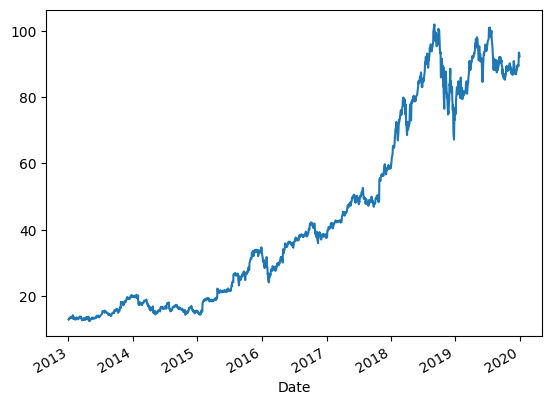

In [3]:
# 아마존의 2013년 부터 2018년까지 일일 주가를 학습 데이터로
# 2019년 데이터를 테스트 데이터로 사용 

AMZN = yf.download('AMZN', 
                  start = '2013-01-01',
                  end = '2019-12-31',
                  progress = False)

# 수정종가(Adj close), 시가(Open), 최고가(High), 최저가(Low), 종가(Close). 거래량(Volume)
all_data = AMZN[['Adj Close', 'Open', 'High','Low',"Close","Volume"]].round(2)
all_data.head(10)

print("There are "+str(all_data[:'2018'].shape[0])+" observations in the training data")
print("There are "+str(all_data['2019':].shape[0])+" observations in the test data")
all_data['Adj Close'].plot()

## 2. RNN/LSTM을 위한 학습데이터 만들기
단변량 주식 가격 시계열로 부터 학습데이터를 생성
* MANY 2 MANY
* MANY 2 ONE

### 2-1. MANY 2 MANY
- 과거 X일의 가격을 사용해서 미래 Y일의 가격을 예측
- 빨간색 창을 시리즈에 따라 움직여서 __샘플__ 을 만듦
- 각 샘플은 5가지 입력값과 2개의 출력값을 가짐
- __타임스텝__ : 각 샘플의 입력값
- __feature__ : 매 타임스텝마다 feature라고 불리는 하나의 숫자를 가짐. feature의 수는 여러개일 수 있음


![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbJf0aY%2FbtqUL9JDeyT%2Fp0MlEeFIYl7SkbRCkDwkW0%2Fimg.png)

### 2-2. MANY 2 ONE
- 출력값 하나

![IMAGE](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FrTfhY%2FbtqVRwhXa0G%2FRxW8kzcRHT2HbXRZlKP2QK%2Fimg.png)

- X가 다차원인 변수를 LSTM 입력을 위해 3차원으로 변형   

![image](https://1.bp.blogspot.com/-As5cOG_Fatc/XMR80nemvGI/AAAAAAAAqds/_xQakPgc0uoXMXPDv9pB9-AJxdjsuDWNACLcBGAs/s640/nn.png)    

![image](https://4.bp.blogspot.com/-duOcCEd9DJU/XMSJD6kzDJI/AAAAAAAAqd4/xlbs2_fbw248QJGkahI5IJJeOHEMBJKdwCLcBGAs/s400/nn2.png)

### 2-3. RNN/LSTM/GRU는 3차원의 배열을 입력
- __Tensor__ : 하나의 텐서는 모델에 들어가는 벡터임
- __Time Step__ : 하나의 타임스텝은 텐서에서 하나의 관측치
- __Feature__ : 한 feature는 그 타임스텝에서 하나의 관측치 

따라서 위의 1차원 배열은 3차원 배열로 변경되어야 함   
--> [# of samples, # of time steps, # of features]    

np.reshape(samples, time steps, features) 로 만듬

## 3. RNN/LSTM/GRU 에 정규화된 데이터 필요함
- 학습 데이터만 스케일 변환에 사용됨(scaler transformation)
- train_x 와 test_x를 독립적으로 스케일링하지 말 것!

In [4]:
def ts_train_test(all_data, time_steps, for_periods): 
    """
    input:
     data: 날짜를 인덱스로 가지는 주식가격(Adj Close) 데이터
    output:
     X_train, y_train: 2013/1/1부터 2018-12/31까지의 데이터
     X_test : 2019년 동안의 데이터 
    time_steps: # input 데이터의 time steps
    for_periods: # output 데이터의 time steps
    """
    # training & test set 만들기
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test = all_data['2019':].iloc[:,0:1].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # training 데이터의 samples 와 time steps로 원본데이터 슬라이싱하기
    X_train = [] 
    y_train = [] 
    y_train_stacked = [] 
    for i in range(time_steps, ts_train_len - 1):
        X_train.append(ts_train[i-time_steps:i,0])
        y_train.append(ts_train[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # 3차원으로 재구성하기
    # np.reshape(samples, time steps, features) 로 만듦
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    
    # Preparing to creat X_test 
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    
    X_test = []
    for i in range(time_steps, ts_test_len+ time_steps- for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    
    return X_train, y_train, X_test 

In [5]:
X_train, y_train, X_test = ts_train_test(all_data,5,2)

# 3차원의 X_train을 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# 3차원의 X_test를 데이터프레임 형식으로 바꿔서 눈으로 확인해보기
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

,0,1,2,3,4
0,67.20,73.54,73.08,73.90,75.10
1,73.54,73.08,73.90,75.10,76.96
2,73.08,73.90,75.10,76.96,75.01
3,73.90,75.10,76.96,75.01,78.77
4,75.10,76.96,75.01,78.77,81.48
...,...,...,...,...,...
244,88.02,88.05,88.46,89.53,89.20
245,88.05,88.46,89.53,89.20,89.61
246,88.46,89.53,89.20,89.61,89.32
247,89.53,89.20,89.61,89.32,89.65


In [6]:
print("There are " + str(X_train.shape[0]) + " samples in the training data")
# There are 1505 samples in the training data

print("There are " + str(X_test.shape[0]) + " samples in the test data")
# There are 249 samples in the test data

There are 1504 samples in the training data
There are 249 samples in the test data


In [8]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    ts_train = all_data[:'2018'].iloc[:,0:1].values
    ts_test = all_data['2019':].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

In [9]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5,2)
X_train.shape[0], X_train.shape[1]

(1504, 5)

In [11]:
# Convert the 3D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see, y_train_see], axis = 1)

# Convert the 3D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 1504 samples in the training data
There are 249 samples in the test data


![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYg4ZQ%2Fbtq01rdsR9T%2F9LzqQhxjAqzrilam8PyXY1%2Fimg.png)

## 4. LSTM 모델

In [22]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers.legacy import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                          momentum = 0.9, nesterov = False),
                          loss = 'mean_squared_error')
    
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

momentum - nesterov

-----
![image](https://github.com/skywalker023/blog_images/blob/master/optimization/nesterov_momentum.png?raw=true)

In [23]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    """
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

/Users/b06/miniforge3/envs/yeardream/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


8/8 [==============================] - 0s 1ms/step


(5.1627917, <Axes: xlabel='Date'>)

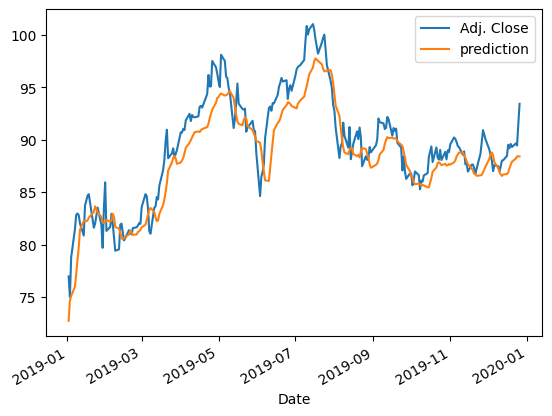

In [24]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)

In [25]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test=all_data.loc['2019':,'Adj Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [27]:
confirm_result(y_test, y_pred)

,Results
MAE,1.82873
RMSE,2.27218
RMSLE,0.02516
R2,0.79936


## 5. GRU 모델
- LSTM 과의 차이점 : cell state와 output gate 가 없음 --> LSTM 보다 파라미터가 적음

In [29]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from keras.optimizers.legacy import SGD 
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 